## Performance Diagnostics and Optimization Strategy
Throughout this process I will be tracking and plotting recall, loss, and accuracy as the key performance indicators. I will be more concerned with recall than with accuracy, because it is most important that the model captures as many of the true postives (cases of pneumonia) as possible, rather than how often any given prediction is correct (i.e. accuracy). This is because this model would be used and a medical diagnostics role and false positives can be easily cross-examined with other means, but it would be a major risk to allow true positives to *slip through the cracks* so-to-sepeak. It would be better to take a bit longer to validate negative cases and not miss any positive cases, than to correctly predict positive or negative *most of the time*.

- First I will compile and train a simple [Baseline Model](#baseline-model)
- Second I will sophisticate the [model architecture](#sophisticating-model-architecture), and the parameters of the [fit function](#sophisticating-the-training-protocol)
- The next step will be to [regularize the network](#network-regularization)



In [17]:
# visualizes accuracy and loss accross training epochs
import matplotlib.pyplot as plt

def visualize_training(model,recall_num:None):

    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    recall = model.history['recall'+recall_num]
    val_recall = model.history['val_recall'+recall_num]
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')

    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')

    plt.legend()
    plt.figure()

    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')

    plt.legend()
    plt.show()

## Generate Data

In [4]:
# dependences for data loading and sifting
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [11]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

In [12]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model
Beginning a convolutional neural network with the most simple architecture for the sake of efficient diagnostics and optimization.  

In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall

The architecture begins with a convolutional 2D layers, followed by a pooling layer, flattened, and then followed up with two dense layers.  
THe model is compiled using binary cross entropy to measure the loss function and accuracy foor the performance metric.

In [18]:

# Your code here; design and compile the model
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))


base_model.compile(loss='binary_crossentropy',
              metrics=['acc',Recall()])

the compiled base model is now fit very lean, using 10 steps per epoch and 5 total epochs, the test data set is used for validation as the actual validation sample is extremely small and reserved only for the final phase of performance evaluation. 

In [19]:
base_model_results = base_model.fit(train_data_generator, 
                              steps_per_epoch=10, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
10/10 [==============================] - 13s 1s/step - loss: 10.7421 - acc: 0.6250 - recall_1: 0.6911 - val_loss: 0.7640 - val_acc: 0.6667 - val_recall_1: 1.0000
Epoch 2/5
10/10 [==============================] - 11s 1s/step - loss: 1.9846 - acc: 0.5625 - recall_1: 0.6455 - val_loss: 1.2844 - val_acc: 0.6417 - val_recall_1: 1.0000
Epoch 3/5
10/10 [==============================] - 12s 1s/step - loss: 1.0332 - acc: 0.7063 - recall_1: 0.7748 - val_loss: 1.1164 - val_acc: 0.6708 - val_recall_1: 1.0000
Epoch 4/5
10/10 [==============================] - 12s 1s/step - loss: 1.0735 - acc: 0.6562 - recall_1: 0.7869 - val_loss: 0.6206 - val_acc: 0.6167 - val_recall_1: 0.4156
Epoch 5/5
10/10 [==============================] - 10s 1s/step - loss: 0.7468 - acc: 0.7000 - recall_1: 0.7632 - val_loss: 1.6586 - val_acc: 0.6542 - val_recall_1: 1.0000


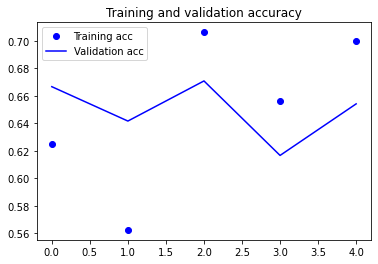

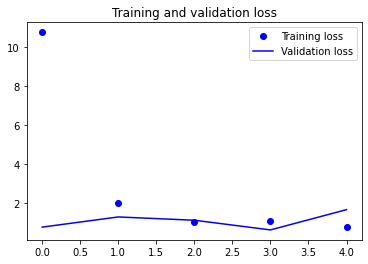

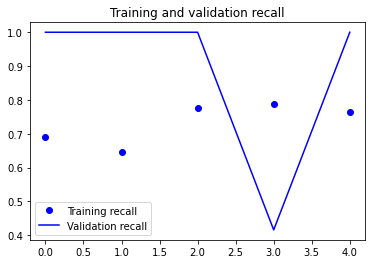

In [34]:
visualize_training(base_model_results,1)

The base model begins stronger than expected with an accuracy of around 70% on the test data (sometimes better or worse, re-running the cell multiple times). A good start, with plenty of room to improve. 

## Sophisticating model architecture

Before exploring tuning and optimization of hyperparameters and other methods such as regularization, we will sophisticate the architectuer of the model itself by incorporating more layers in a variety of types including convolutional layers, pooling layers, and dense layers. 

In [29]:
deep_model = models.Sequential()

deep_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Flatten())
deep_model.add(layers.Dense(512, activation='relu'))
deep_model.add(layers.Dense(256, activation='relu'))
deep_model.add(layers.Dense(1, activation='sigmoid'))

deep_model.compile(loss='binary_crossentropy',
              metrics=['acc',Recall()])

In [30]:
deep_model_results = deep_model.fit(train_data_generator, 
                              steps_per_epoch=10, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
10/10 [==============================] - 9s 886ms/step - loss: 1.4988 - acc: 0.6750 - recall_2: 0.8175 - val_loss: 0.6676 - val_acc: 0.6375 - val_recall_2: 1.0000
Epoch 2/5
10/10 [==============================] - 8s 792ms/step - loss: 0.5369 - acc: 0.7875 - recall_2: 1.0000 - val_loss: 0.6632 - val_acc: 0.6333 - val_recall_2: 1.0000
Epoch 3/5
10/10 [==============================] - 9s 900ms/step - loss: 0.5945 - acc: 0.7500 - recall_2: 1.0000 - val_loss: 0.6349 - val_acc: 0.6125 - val_recall_2: 1.0000
Epoch 4/5
10/10 [==============================] - 8s 777ms/step - loss: 0.5104 - acc: 0.7500 - recall_2: 0.9250 - val_loss: 0.8945 - val_acc: 0.5750 - val_recall_2: 1.0000
Epoch 5/5
10/10 [==============================] - 8s 784ms/step - loss: 0.4761 - acc: 0.7437 - recall_2: 0.8264 - val_loss: 0.6357 - val_acc: 0.6500 - val_recall_2: 0.9933


In [32]:
deep_model_results.history

{'loss': [1.4988062381744385,
  0.5368684530258179,
  0.5945476293563843,
  0.5104217529296875,
  0.47614654898643494],
 'acc': [0.675000011920929,
  0.7875000238418579,
  0.75,
  0.75,
  0.7437499761581421],
 'recall_2': [0.817460298538208,
  1.0,
  1.0,
  0.925000011920929,
  0.8264462947845459],
 'val_loss': [0.6676232218742371,
  0.6631858348846436,
  0.6349177956581116,
  0.8945318460464478,
  0.6357223391532898],
 'val_acc': [0.637499988079071,
  0.6333333253860474,
  0.612500011920929,
  0.574999988079071,
  0.6499999761581421],
 'val_recall_2': [1.0, 1.0, 1.0, 1.0, 0.9933333396911621]}

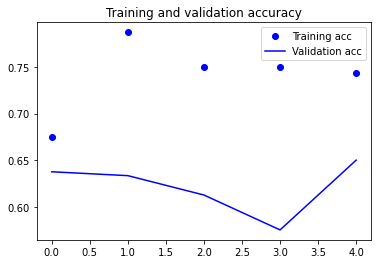

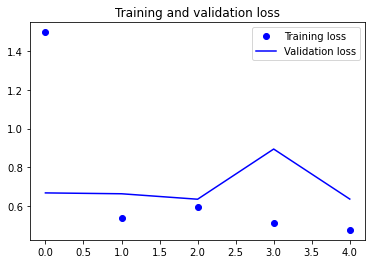

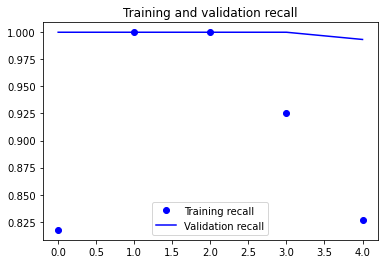

In [35]:
visualize_training(deep_model_results,2)

## sophisticating the training protocol

The deeper model's final results and history (visualized above) is showing clear signs of overfitting. The next step I will take is sophisticating the parameters of the fit function being used. My intuition is that the fit function is too simple relative to the complexity of the model architecture. 

In [36]:
fitter_model_results = deep_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/15
50/50 [==============================] - 29s 589ms/step - loss: 0.3293 - acc: 0.8662 - recall_2: 0.9175 - val_loss: 1.0059 - val_acc: 0.7225 - val_recall_2: 0.9839
Epoch 2/15
50/50 [==============================] - 29s 575ms/step - loss: 0.2257 - acc: 0.9175 - recall_2: 0.9394 - val_loss: 0.6623 - val_acc: 0.8125 - val_recall_2: 0.9728
Epoch 3/15
50/50 [==============================] - 29s 580ms/step - loss: 0.2030 - acc: 0.9225 - recall_2: 0.9489 - val_loss: 0.6827 - val_acc: 0.8100 - val_recall_2: 0.9729
Epoch 4/15
50/50 [==============================] - 50s 993ms/step - loss: 0.1496 - acc: 0.9362 - recall_2: 0.9460 - val_loss: 0.8380 - val_acc: 0.7425 - val_recall_2: 1.0000
Epoch 5/15
50/50 [==============================] - 36s 725ms/step - loss: 0.1365 - acc: 0.9488 - recall_2: 0.9653 - val_loss: 0.7911 - val_acc: 0.7875 - val_recall_2: 0.9880
Epoch 6/15
50/50 [==============================] - 32s 633ms/step - loss: 0.1228 - acc: 0.9663 - recall_2: 0.9783 - val_loss

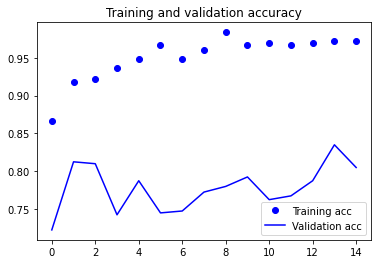

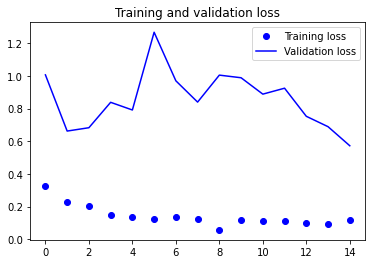

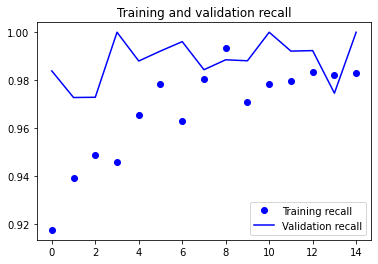

In [39]:
visualize_training(fitter_model_results,2)

The accuracy and loss on training data is begining to behave more as desired; however on the test data the history is still quite eratic indicating that the model is still overfitting and not able to generalize consistently. All that considered the final accuracy on the training data is the best so far so we're moving in the right direction.

## Network Regularization

### L2 regularization
I will begin regularizing the network by incorporating L2 regularization on the dense layers of the existing model architecture

In [7]:
from keras.regularizers import l2

L2_model = models.Sequential()

L2_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(1, activation='sigmoid'))

L2_model.compile(loss='binary_crossentropy',
              metrics=['acc',Recall()])

In [13]:
# added 5 epochs from the last fit call
L2_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/20
50/50 [==============================] - 39s 782ms/step - loss: 1.8281 - acc: 0.7200 - recall: 0.9463 - val_loss: 0.9511 - val_acc: 0.7175 - val_recall: 0.6181
Epoch 2/20
50/50 [==============================] - 39s 772ms/step - loss: 0.7089 - acc: 0.8150 - recall: 0.9086 - val_loss: 0.8767 - val_acc: 0.6850 - val_recall: 0.9763
Epoch 3/20
50/50 [==============================] - 38s 759ms/step - loss: 0.4996 - acc: 0.8575 - recall: 0.9217 - val_loss: 0.5486 - val_acc: 0.8450 - val_recall: 0.8916
Epoch 4/20
50/50 [==============================] - 40s 793ms/step - loss: 0.3456 - acc: 0.9087 - recall: 0.9456 - val_loss: 0.8817 - val_acc: 0.7275 - val_recall: 0.9920
Epoch 5/20
50/50 [==============================] - 56s 1s/step - loss: 0.3574 - acc: 0.9038 - recall: 0.9445 - val_loss: 0.4441 - val_acc: 0.8550 - val_recall: 0.8798
Epoch 6/20
50/50 [==============================] - 47s 935ms/step - loss: 0.3088 - acc: 0.9300 - recall: 0.9538 - val_loss: 0.8970 - val_acc: 0.742

In [14]:
L2_model_results.history

{'loss': [1.828128457069397,
  0.7089298367500305,
  0.49958857893943787,
  0.3456038236618042,
  0.3574431538581848,
  0.30881571769714355,
  0.28168797492980957,
  0.23389838635921478,
  0.2528262734413147,
  0.2553277909755707,
  0.22696515917778015,
  0.21683922410011292,
  0.22377699613571167,
  0.1975889652967453,
  0.2046453356742859,
  0.19699646532535553,
  0.17491783201694489,
  0.15506061911582947,
  0.19791685044765472,
  0.16600315272808075],
 'acc': [0.7200000286102295,
  0.8149999976158142,
  0.8575000166893005,
  0.9087499976158142,
  0.9037500023841858,
  0.9300000071525574,
  0.9362499713897705,
  0.9449999928474426,
  0.9437500238418579,
  0.9412500262260437,
  0.9487500190734863,
  0.9424999952316284,
  0.9512500166893005,
  0.949999988079071,
  0.9524999856948853,
  0.9574999809265137,
  0.9587500095367432,
  0.9700000286102295,
  0.949999988079071,
  0.9662500023841858],
 'recall': [0.9463087320327759,
  0.9086378812789917,
  0.92166668176651,
  0.9456342458724976

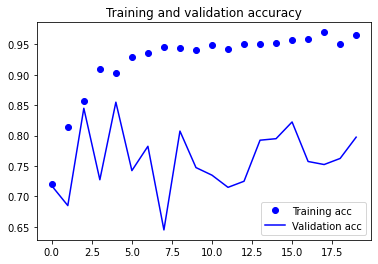

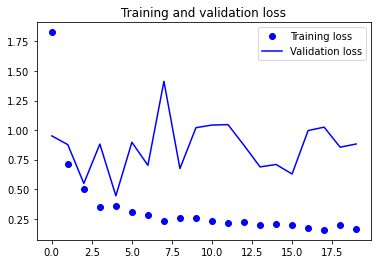

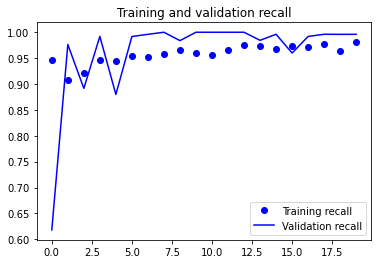

In [20]:
visualize_training(L2_model_results,"")

L2 regularization appears to have resolved overfitting at least as far a recall is concerned. The recall is nearly perfect, however the validation loss is very high, considering this alongside that validation accuracy tends to hangout around 75%, my interpretation is that the model is predicting almost all true positive cases, while also making a considrable amount of false positive predictions. This is exactly the behaviour I am looking for. The recall is well within an acceptable margin; in the interest of the end user however (i.e. the medical profesionals) I want to reduce the rate of false positives. This would reduce the amount of manual human effort required to validate diagnoses made by the model saving both time and money for both patients and service providers.  

### Dropout regularization